This Notebook is made for part-taking in https://www.kaggle.com/competitions/playground-series-s3e22

The goal is to make a prediction of Horse Survival based on the medical data for that horse.
I will conduct analysis and model preparation on train data provided by Kaggle, and the test data will be used to generate submissions.

#### Imports

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading the Data

In [22]:
df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)

# train and test df's were synthesized from the original dataset, 
# features should have similar but not the same distributions
og_df = pd.read_csv('horse.csv')

In [23]:
df.head(5)

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1196 non-null   object 
 7   peripheral_pulse       1175 non-null   object 
 8   mucous_membrane        1214 non-null   object 
 9   capillary_refill_time  1229 non-null   object 
 10  pain                   1191 non-null   object 
 11  peristalsis            1215 non-null   object 
 12  abdominal_distention   1212 non-null   object 
 13  nasogastric_tube       1155 non-null   object 
 14  nasogastric_reflux     1214 non-null   object 
 15  nasogastr

#### Basic Comparison of few features of Original Data and Competition Data 

In [25]:
print("Original Columns:", og_df.columns)

print("\nOriginal columns not present in train:", set(og_df.columns) - set(df.columns))
print("Train columns not present in original:", set(df.columns) - set(og_df.columns))

og_df = og_df.loc[:, df.columns] # re-order columns to match train 

Original Columns: Index(['surgery', 'age', 'hospital_number', 'rectal_temp', 'pulse',
       'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen',
       'packed_cell_volume', 'total_protein', 'abdomo_appearance',
       'abdomo_protein', 'outcome', 'surgical_lesion', 'lesion_1', 'lesion_2',
       'lesion_3', 'cp_data'],
      dtype='object')

Original columns not present in train: set()
Train columns not present in original: set()


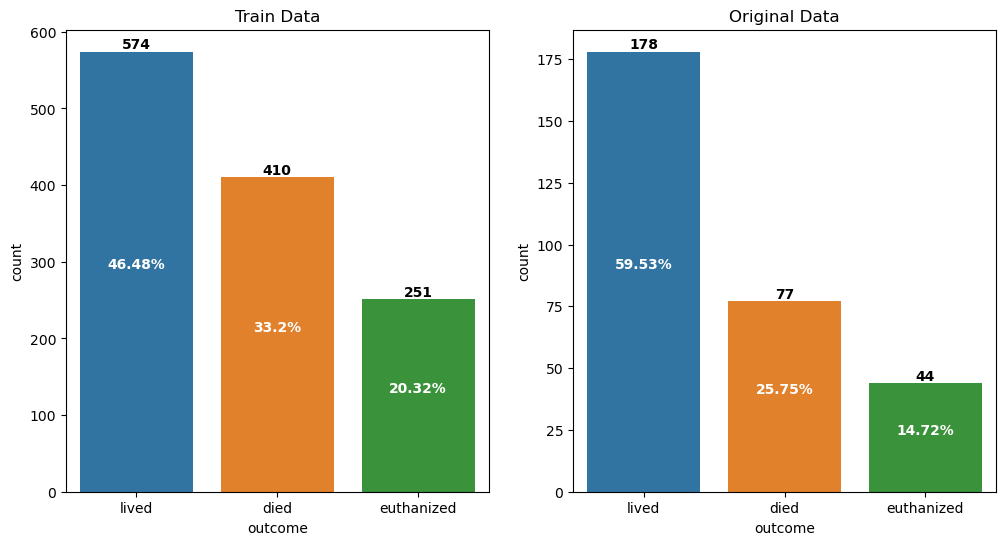

In [46]:
# Plot distributions of target "outcome" column using seaborn in both train and original data.
# Plot them next to each other

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

sns.countplot(x='outcome', data=df, order=['lived', 'died', 'euthanized'])

# Plot the count number on bar and percentage
for i, v in enumerate(df['outcome'].value_counts().values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')
    plt.text(i, v/2, str(round(v/len(df)*100, 2))+'%', ha='center', va='bottom', fontweight='bold', color='white')

plt.title('Train Data')

plt.subplot(1, 2, 2)
sns.countplot(x='outcome', data=og_df, order=['lived', 'died', 'euthanized'])

for i, v in enumerate(og_df['outcome'].value_counts().values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')
    plt.text(i, v/2, str(round(v/len(og_df)*100, 2))+'%', ha='center', va='bottom', fontweight='bold', color='white')

plt.title('Original Data')

plt.show()

Original Data has more occurences of lived horses. Compared to other labels

**Idea**: 
Died and Euthanized might be more similar to each other compared to lived (in both cases horses health is probably criticall)
What if we make two models. One describes whether the horse will live. And the second one describing whether it will be euthanized.
<br>
**There are some features present that might be more usefull in one case more than in another.**
<br>
*Example: Hospital*

In [52]:
df["hospital_number"]

id
0        530001
1        533836
2        529812
3       5262541
4       5299629
         ...   
1230     535246
1231     528570
1232     529685
1233     534784
1234     528548
Name: hospital_number, Length: 1235, dtype: int64

In [97]:
# Display unique values of all categorical data columns

print("Train data catagories", 
      *list(df.loc[:, df.dtypes == 'object']  # Get only categorical columns
              .apply(lambda x: x.name + ": " + ", ".join(x.unique().astype(str)))  # Format it to print-friendly string
              ), sep='\n')  # Print each column on new line

print("\nTrain data catagories", 
      *list(df.loc[:, df.dtypes == 'object']
              .apply(lambda x: x.name + ": " + ", ".join(x.unique().astype(str)))
              ), sep='\n')

Train data catagories
surgery: yes, no
age: adult, young
temp_of_extremities: cool, cold, normal, warm, nan
peripheral_pulse: reduced, normal, nan, absent, increased
mucous_membrane: dark_cyanotic, pale_cyanotic, pale_pink, normal_pink, bright_pink, bright_red, nan
capillary_refill_time: more_3_sec, less_3_sec, nan, 3
pain: depressed, mild_pain, extreme_pain, alert, severe_pain, nan, slight
peristalsis: absent, hypomotile, normal, hypermotile, nan, distend_small
abdominal_distention: slight, moderate, none, severe, nan
nasogastric_tube: slight, none, significant, nan
nasogastric_reflux: less_1_liter, more_1_liter, none, nan, slight
rectal_exam_feces: decreased, absent, nan, normal, increased, serosanguious
abdomen: distend_small, distend_large, normal, firm, nan, other
abdomo_appearance: serosanguious, cloudy, clear, nan
surgical_lesion: yes, no
cp_data: no, yes
outcome: died, euthanized, lived

Train data catagories
surgery: yes, no
age: adult, young
temp_of_extremities: cool, cold, n

All categories are consistent. It might be interesting to **check whether in some instances nan and None values should be equal.** <br>
However I am not too enthusiastic about this idea as both in og and train data the same structure is present.

In [110]:
# Finnaly describe all numerical columns in train data and original data
pd.concat([
    df.loc[:, (df.dtypes != "object") & (df.columns != "hospital_number")].describe(),
    og_df.loc[:, (og_df.dtypes != "object") & (og_df.columns != "hospital_number")].describe()
    ], keys=['Train', 'Original'], axis=0).T

Train                                                   
                        count         mean          std   min     25%     50%   
rectal_temp            1235.0    38.202186     0.788668  35.4    37.8    38.2  \
pulse                  1235.0    79.574089    29.108638  30.0    53.0    76.0   
respiratory_rate       1235.0    30.054251    16.452066   8.0    18.0    28.0   
nasogastric_reflux_ph  1235.0     4.382591     1.937357   1.0     2.0     4.5   
packed_cell_volume     1235.0    49.602429    10.535800  23.0    43.0    48.0   
total_protein          1235.0    21.388016    26.676453   3.5     6.6     7.5   
abdomo_protein         1235.0     3.290931     1.589195   0.1     2.0     3.0   
lesion_1               1235.0  3832.496356  5436.733774   0.0  2205.0  2209.0   
lesion_2               1235.0    14.612146   193.705735   0.0     0.0     0.0   
lesion_3               1235.0     3.577328    88.858953   0.0     0.0     0.0   

                                       Original                             
                          75%      max    count         mean          std   
rectal_temp              38.6     40.8    239.0    38.168619     0.733744  \
pulse                   100.0    184.0    275.0    72.000000    28.646219   
respiratory_rate         36.0     96.0    241.0    30.460581    17.666102   
nasogastric_reflux_ph     6.0      7.5     53.0     4.707547     1.982311   
packed_cell_volume       57.0     75.0    270.0    46.307407    10.436743   
total_protein             9.1     89.0    266.0    24.274436    27.364194   
abdomo_protein            4.3     10.1    101.0     3.039604     1.967947   
lesion_1               3205.0  41110.0    299.0  3659.709030  5408.472421   
lesion_2                  0.0   3112.0    299.0    90.528428   650.637139   
lesion_3                  0.0   2209.0    299.0     7.387960   127.749768   

                                                               
                        min     25%     50%      75%      max  
rectal_temp            35.4    37.8    38.2    38.50     40.8  
pulse                  30.0    48.0    64.0    88.00    184.0  
respiratory_rate        8.0    18.0    25.0    36.00     96.0  
nasogastric_reflux_ph   1.0     3.0     5.0     6.50      7.5  
packed_cell_volume     23.0    38.0    45.0    52.00     75.0  
total_protein           3.3     6.5     7.5    56.75     89.0  
abdomo_protein          0.1     2.0     2.3     3.90     10.1  
lesion_1                0.0  2111.5  2322.0  3209.00  41110.0  
lesion_2                0.0     0.0     0.0     0.00   7111.0  
lesion_3                0.0     0.0     0.0     0.00   2209.0

There might be some outliers in lesion columns

I will probably back to using original data insights, however for this moment let's focus on train_df 

#### EDA of train.csv